In [1]:
cd ../..

/disk1/home/svo6059/masters/spikelearn


# Environment

## Imports

In [2]:
import sys
sys.path.append('.')
import os
from spikelearn import frankenstein, shuffle_val_predict
from spikelearn.models import shuffle_cross_predict
from spikelearn.data import io, SHORTCUTS, select, to_feature_array
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd

from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, cross_val_predict, GroupKFold
import numpy as np

from scipy.stats import ttest_rel

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from itertools import product
from spikelearn.models.shuffle_decoding import MonteCarloFeatures

from spikelearn.measures.univariate import bracketing

## Functions 

In [4]:
def label_last_times(df, timewindow=200, offset=0, bootstrap=False):
    assert df['time'].nunique() == df['time'].shape[0]
    if bootstrap:
        target_time = df['time'][df['time']>-300].sample().values[0]
    else:
        target_time = df['time'].max() - offset
    df['label'] = ((df['time'] >= (target_time - timewindow)) &
                   (df['time'] <=  target_time) )
    return df

In [5]:
def to_response_df(df, btime=200, Xyt=False, offset=0, bootstrap=False):
    """
    Returns a dataframe of features as columns, 
    with examples labeled as 1 if they are between _btime_ ms of the exiting time
    """
    subset= ['full', 'full_times']
    df = df.copy()[subset]

    rates = pd.DataFrame(df[subset[0]].tolist(),
                index=df.index).reset_index().melt(['trial','unit'])
    times = pd.DataFrame(df[subset[1]].tolist(),
                index=df.index).reset_index().melt(['trial','unit'])

    rates['time'] = times.value
    rates = rates.drop('variable',axis=1).dropna()
    rates = rates.set_index(['unit','trial','time']).unstack(0).reset_index()
    rates = rates.groupby('trial').apply(label_last_times, offset=offset, bootstrap=bootstrap, timewindow=btime)\
                                  .set_index(['trial','label', 'time'])
    rates.columns = rates.columns.droplevel()
    if Xyt:
        X = rates.values
        rates = rates.reset_index()
        y = rates['label'].values
        trial = rates['trial'].values
        time = rates['time'].values
        return X, y, trial, time
    else:
        return rates

In [6]:
def bracket_analysis(rat, border_size, boot=False, strpfc=None, day=None):
    if 'ELI' not in rat:
        rat = select(io.load(rat, 'no_smoothing'), _min_duration=1.5, is_selected=True, is_tired=False)
    else:
        kwargs = {}
        if strpfc is not None:
            kwargs['area'] = strpfc
        rat = select(io.load(rat, 'no_smoothing'), _min_duration=1.5, **kwargs)
        
    data = to_response_df(rat).reset_index('label', drop=True)
    
    mean_act = data.mean(axis=1).unstack()
    nbins = (mean_act.isnull()==False).sum(axis=1)
    mean_act['nbins'] = nbins
    bracket = mean_act.apply(lambda S: bracketing(S.values[:-1], 2, (5,S.nbins-1)), axis=1)
    return bracket

### Visualization 

# Exploratory Analysis  

## First day

In [7]:
full_bk = pd.DataFrame()
for rat in SHORTCUTS['groups']['eletro']:
    bracket_val = bracket_analysis(rat, 2)
    rat_bk = pd.DataFrame(bracket_val, columns=['value']).reset_index()
    rat_bk['rat'] = rat
    rat_bk['second_half'] = rat_bk.trial > rat_bk.trial.median()
    rat_bk['normalized_bracket'] = rat_bk.value - rat_bk.value.mean()
    full_bk = full_bk.append(rat_bk)

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


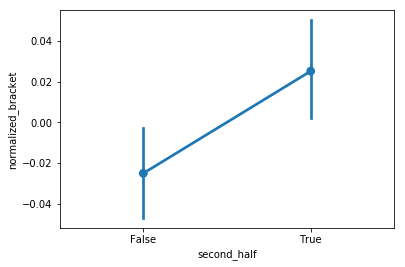

In [8]:
sns.pointplot(x='second_half', y='normalized_bracket', data=full_bk)

In [19]:
full_bk['day'] = full_bk.rat.str.contains('_2')

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


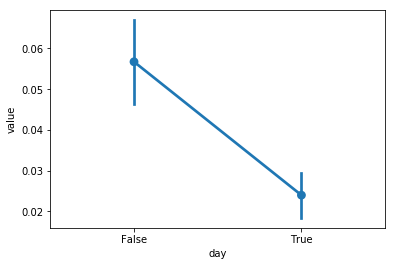

In [21]:
sns.pointplot(x='day', y='value', data=full_bk[full_bk.rat.str.contains('LI')])

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


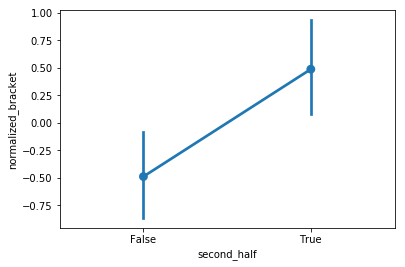

In [114]:
sns.pointplot(x='second_half', y='normalized_bracket', data=full_bk)

In [140]:
means = full_bk.groupby(['rat', 'second_half']).mean().value.unstack('second_half').values

In [141]:
ttest_rel(means[:,0], means[:,1])

Ttest_relResult(statistic=-1.932361466116536, pvalue=0.09459291003054363)

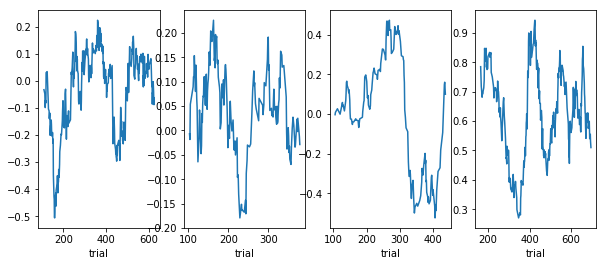

In [53]:
fig, ax = plt.subplots(1, 4, figsize=(10,4))
for i in range(4):
    bracket_analysis('ELI %d_2'%(3+i), 2, strpfc='STR').rolling(50).mean().plot(ax=ax[i])

## First vs second day 

In [154]:
bk_values_days = pd.DataFrame()
for rat in SHORTCUTS['groups']['EZ']:
    bracket_val = bracket_analysis(rat, 2)
    rat_bk = pd.DataFrame(bracket_val, columns=['value']).reset_index()
    rat_bk['day'] = 2 if '_2' in rat else 1
    rat_bk['rat'] = rat.replace('_2', '')
    bk_values_days = bk_values_days.append(rat_bk)

In [155]:
bk_values_days.groupby(['rat', 'day']).value.mean()

rat    day
ELI 3  1     -0.009493
       2     -0.001687
ELI 4  1      0.002851
       2      0.002884
ELI 5  1      0.013273
       2      0.008179
ELI 6  1      0.059442
       2      0.061566
Name: value, dtype: float64

# Final analysis

In [156]:
%%time
eli_rats={}
for i, rat, area in product(range(20), SHORTCUTS['groups']['EZ'], ['STR', 'PFC']):
    %time eli_rats[(rat, i, area)] = onset_rmse(rat, i*100, False, area)

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

NameError: name 'onset_rmse' is not defined

CPU times: user 1.8 s, sys: 112 ms, total: 1.91 s
Wall time: 1.8 s


In [157]:
eli_df = pd.DataFrame(eli_rats, index=['rmse']).T.reset_index()
eli_df.columns = ['rat', 'offset', 'area', 'rmse']
eli_df['offset'] = eli_df['offset']*(-100)
eli_df.head()

ValueError: Length mismatch: Expected axis has 2 elements, new values have 4 elements

In [57]:
eli_df['day'] = eli_df.rat.str.contains('_2').astype(int)+1
eli_df.loc[eli_df['day']==2, 'rat'] = eli_df['rat'].apply(lambda s: s[:-2])

NameError: name 'eli_df' is not defined

In [20]:
eli_df.head()

,rat,offset,area,rmse,day
0,ELI 3,0,STR,1439.413442,1
1,ELI 3,0,PFC,1413.261345,1
2,ELI 5,0,STR,1404.761925,1
3,ELI 6,0,PFC,1559.179838,1
4,ELI 4,0,PFC,1778.380841,2


In [55]:
sns.lineplot(x='offset', y='rmse', hue='day', style='area', data=eli_df[eli_df.rat=='ELI 3'])

NameError: name 'eli_df' is not defined

In [58]:
eli_df.day.value_counts()

2    120
1    104
Name: day, dtype: int64

# Old

## Testing

In [75]:
rat = select(io.load('DRRD 8', 'wide_smoothed'), _min_duration=1.5, is_selected=True, is_tired=False)
X, y, t, time = to_response_df(rat, 200, True, 300)

### Cross predicting 

In [79]:
res = cross_val_predict(pipe, X, y, t, cv=10)
res = pd.DataFrame(np.stack((t, y, res, time)).T)
res.columns=['trial', 'true', 'pred', 'time']

### Cross validating metrics

In [82]:
mean_predicted_onset = res[res.pred.astype(bool)].groupby('trial')['time'].mean()
mean_true_onset = res[res.true.astype(bool)].groupby('trial')['time'].mean()

In [83]:
np.sqrt((mean_true_onset - mean_predicted_onset).dropna()**2).mean()

575.2128518503328

In [ ]:
pipe = make_pipeline(RobustScaler(),
                         RandomUnderSampler(),
                         LogisticRegression(solver='lbfgs'))

scoring=['roc_auc', 'precision', 'recall', 'accuracy', 'f1']
res = pd.DataFrame(cross_validate(pipe, X, y, t, scoring, GroupKFold(10), return_train_score=True))
res.mean()

In [12]:
pipe = make_pipeline(RobustScaler(),
                         LogisticRegression(solver='lbfgs'))

scoring=['roc_auc', 'precision', 'recall', 'accuracy', 'f1']
res = pd.DataFrame(cross_validate(pipe, X, y, t, scoring, 10, return_train_score=True))
res

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy,test_f1,train_f1
0,0.120475,0.009295,0.898936,0.898220,0.635135,0.726244,0.505376,0.386282,0.911515,0.914914,0.562874,0.504321
1,0.103257,0.008828,0.896116,0.899148,0.762712,0.713318,0.483871,0.380265,0.924848,0.913430,0.592105,0.496075
2,0.099069,0.008767,0.908632,0.899035,0.718750,0.729258,0.247312,0.401925,0.904242,0.916262,0.368000,0.518231
3,0.084529,0.007577,0.862991,0.902381,0.500000,0.747788,0.268817,0.406739,0.887273,0.918150,0.349650,0.526890
4,0.079583,0.005551,0.931234,0.895155,0.745098,0.719178,0.413043,0.378606,0.918689,0.913712,0.531469,0.496063
5,0.073768,0.007553,0.890027,0.898927,0.680000,0.739819,0.369565,0.393029,0.910194,0.916408,0.478873,0.513344
6,0.089525,0.007745,0.876975,0.899600,0.702703,0.723684,0.282609,0.396635,0.906553,0.915330,0.403101,0.512422
7,0.092046,0.007651,0.888286,0.899348,0.735849,0.718121,0.423913,0.385817,0.918591,0.914128,0.537931,0.501955
8,0.099251,0.007529,0.874695,0.900708,0.719298,0.719027,0.445652,0.390625,0.918591,0.914532,0.550336,0.506231
9,0.084130,0.007535,0.862532,0.901745,0.780488,0.720982,0.347826,0.388221,0.916160,0.914532,0.481203,0.504688
